In [93]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.autograd as autograd
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils import data
from torch.nn import Conv2d, ConvTranspose2d, BatchNorm2d, LeakyReLU, ReLU, Tanh
from torchvision import datasets, transforms, utils

In [94]:
def log_odds(p):
  p = torch.clamp(p.mean(dim=0), 1e-7, 1-1e-7)
  return torch.log(p / (1 - p))

In [96]:
class MaxOut(nn.Module):
    def __init__(self, k=2):
        super().__init__()

        self.k = k

    def forward(self, input):
        output_dim = input.size(1) // self.k
        input = input.view(input.size(0), output_dim, self.k, input.size(2), input.size(3))
        output, _ = input.max(dim=2)
        return output

In [97]:
class DeterministicConditional(nn.Module):
  def __init__(self, mapping, shift=None):
   
    super().__init__()

    self.mapping = mapping
    self.shift = shift

  def set_shift(self, value):
    if self.shift is None:
      return
    assert list(self.shift.data.size()) == list(value.size())
    self.shift.data = value

  def forward(self, input):
    output = self.mapping(input)
    if self.shift is not None:
      output = output + self.shift
    return output

In [98]:
class GaussianConditional(nn.Module):
  def __init__(self, mapping, shift=None):

    super().__init__()

    self.mapping = mapping
    self.shift = shift

  def set_shift(self, value):
    if self.shift is None:
      return
    assert list(self.shift.data.size()) == list(value.size())
    self.shift.data = value

  def forward(self, input):
    params = self.mapping(input)
    nlatent = params.size(1) // 2
    mu, log_sigma = params[:, :nlatent], params[:, nlatent:]
    sigma = log_sigma.exp()
    eps = torch.randn(mu.size()).to(input.device)
    output = mu + sigma * eps
    if self.shift is not None:
      output = output + self.shift
    return output

In [99]:
class JointCritic(nn.Module):
  def __init__(self, x_mapping, z_mapping, joint_mapping):
    super().__init__()

    self.x_net = x_mapping
    self.z_net = z_mapping
    self.joint_net = joint_mapping

  def forward(self, x, z):
    assert x.size(0) == z.size(0)
    x_out = self.x_net(x)
    z_out = self.z_net(z)
    joint_input = torch.cat((x_out, z_out), dim=1)
    output = self.joint_net(joint_input)
    return output

In [100]:
class Wass(nn.Module):
  def __init__(self, E, G, C):

    super().__init__()

    self.E = E
    self.G = G
    self.C = C

  def get_encoder_parameters(self):
    return self.E.parameters()

  def get_generator_parameters(self):
    return self.G.parameters()

  def get_critic_parameters(self):
    return self.C.parameters()

  def encode(self, x):
    return self.E(x)

  def generate(self, z):
    return self.G(z)

  def reconstruct(self, x):
    return self.generate(self.encode(x))

  def criticize(self, x, z_hat, x_tilde, z):
    input_x = torch.cat((x, x_tilde), dim=0)
    input_z = torch.cat((z_hat, z), dim=0)
    output = self.C(input_x, input_z)
    data_preds, sample_preds = output[:x.size(0)], output[x.size(0):]
    return data_preds, sample_preds

  def calculate_grad_penalty(self, x, z_hat, x_tilde, z):
    bsize = x.size(0)
    eps = torch.rand(bsize, 1, 1, 1).to(x.device) # eps ~ Unif[0, 1]
    intp_x = eps * x + (1 - eps) * x_tilde
    intp_z = eps * z_hat + (1 - eps) * z
    intp_x.requires_grad = True
    intp_z.requires_grad = True
    C_intp_loss = self.C(intp_x, intp_z).sum()
    grads = autograd.grad(C_intp_loss, (intp_x, intp_z), retain_graph=True, create_graph=True)
    grads_x, grads_z = grads[0].view(bsize, -1), grads[1].view(bsize, -1)
    grads = torch.cat((grads_x, grads_z), dim=1)
    grad_penalty = ((grads.norm(2, dim=1) - 1) ** 2).mean()
    return grad_penalty

  def forward(self, x, z, lamb=10):
    z_hat, x_tilde = self.encode(x), self.generate(z)
    data_preds, sample_preds = self.criticize(x, z_hat, x_tilde, z)
    EG_loss = torch.mean(data_preds - sample_preds)
    C_loss = -EG_loss + lamb * self.calculate_grad_penalty(x.data, z_hat.data, x_tilde.data, z.data)
    return C_loss, EG_loss

In [101]:
cudnn.benchmark = True
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)

In [137]:
BATCH_SIZE = 128
ITER = 50
IMAGE_SIZE = 64
NUM_CHANNELS = 3
DIM = 64
NLAT = 100
LEAK = 0.2

C_ITERS = 5       
EG_ITERS = 1      
LAMBDA = 10       
LEARNING_RATE = 1e-4
BETA1 = 0.5
BETA2 = 0.9

In [138]:
def create_encoder():
  mapping = nn.Sequential(
    Conv2d(NUM_CHANNELS, DIM, 4, 2, 1, bias=False), BatchNorm2d(DIM), ReLU(inplace=True),
    Conv2d(DIM, DIM * 2, 4, 2, 1, bias=False), BatchNorm2d(DIM * 2), ReLU(inplace=True),
    Conv2d(DIM * 2, DIM * 4, 4, 2, 1, bias=False), BatchNorm2d(DIM * 4), ReLU(inplace=True),
    Conv2d(DIM * 4, DIM * 8, 4, 2, 1, bias=False), BatchNorm2d(DIM * 8), ReLU(inplace=True),
    Conv2d(DIM * 8, DIM * 8, 4, 1, 0, bias=False), BatchNorm2d(DIM * 8), ReLU(inplace=True),
    Conv2d(DIM * 8, NLAT, 1, 1))
  return DeterministicConditional(mapping)

In [139]:
def create_generator():
  mapping = nn.Sequential(
    ConvTranspose2d(NLAT, DIM * 8, 4, 1, 0, bias=False), BatchNorm2d(DIM * 8), ReLU(inplace=True),
    ConvTranspose2d(DIM * 8, DIM * 4, 4, 2, 1, bias=False), BatchNorm2d(DIM * 4), ReLU(inplace=True),
    ConvTranspose2d(DIM * 4, DIM * 2, 4, 2, 1, bias=False), BatchNorm2d(DIM * 2), ReLU(inplace=True),
    ConvTranspose2d(DIM * 2, DIM, 4, 2, 1, bias=False), BatchNorm2d(DIM), ReLU(inplace=True),
    ConvTranspose2d(DIM, NUM_CHANNELS, 4, 2, 1, bias=False), Tanh())
  return DeterministicConditional(mapping)

In [140]:
def create_critic():
  x_mapping = nn.Sequential(
    Conv2d(NUM_CHANNELS, DIM, 4, 2, 1), LeakyReLU(LEAK),
    Conv2d(DIM, DIM * 2, 4, 2, 1), LeakyReLU(LEAK),
    Conv2d(DIM * 2, DIM * 4, 4, 2, 1), LeakyReLU(LEAK),
    Conv2d(DIM * 4, DIM * 8, 4, 2, 1), LeakyReLU(LEAK),
    Conv2d(DIM * 8, DIM * 8, 4, 1, 0), LeakyReLU(LEAK))

  z_mapping = nn.Sequential(
    Conv2d(NLAT, 512, 1, 1, 0), LeakyReLU(LEAK),
    Conv2d(512, 512, 1, 1, 0), LeakyReLU(LEAK))

  joint_mapping = nn.Sequential(
    Conv2d(DIM * 8 + 512, 2048, 1, 1, 0), LeakyReLU(LEAK),
    Conv2d(2048, 2048, 1, 1, 0), LeakyReLU(LEAK),
    Conv2d(2048, 1, 1, 1, 0))

  return JointCritic(x_mapping, z_mapping, joint_mapping)

In [141]:
def create_Wass():
  E = create_encoder()
  G = create_generator()
  C = create_critic()
  wass = Wass(E, G, C)
  return wass

In [142]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
wass = create_Wass().to(device)

optimizerEG = Adam(list(wass.get_encoder_parameters()) + list(wass.get_generator_parameters()), 
    lr=LEARNING_RATE, betas=(BETA1, BETA2))
optimizerC = Adam(wass.get_critic_parameters(),
    lr=LEARNING_RATE, betas=(BETA1, BETA2))

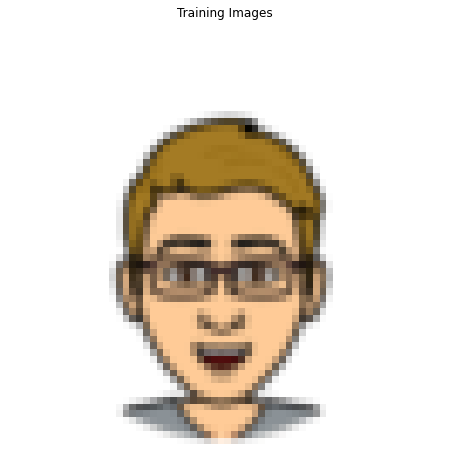

In [143]:
dataroot = "Downloads/archive (8)"

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE), transforms.CenterCrop(IMAGE_SIZE), transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataloader = datasets.ImageFolder(dataroot, transform=transform)
loader = data.DataLoader(dataloader, BATCH_SIZE, shuffle=True, num_workers=2)

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [144]:
  noise = torch.randn(64, NLAT, 1, 1, device=device)

  EG_losses, C_losses = [], []
  curr_iter = C_iter = EG_iter = 0
  C_update, EG_update = True, False
  print('Training starts...')

  while curr_iter < ITER:
    for batch_idx, (x, _) in enumerate(loader, 1):
      x = x.to(device)

      if curr_iter == 0:
        init_x = x
        curr_iter += 1

      z = torch.randn(x.size(0), NLAT, 1, 1).to(device)
      C_loss, EG_loss = wass(x, z, lamb=LAMBDA)
      
      if C_update:
        optimizerC.zero_grad()
        C_loss.backward()
        C_losses.append(C_loss.item())
        optimizerC.step()
        C_iter += 1

        if C_iter == C_ITERS:
          C_iter = 0
          C_update, EG_update = False, True
        continue

      if EG_update:
        optimizerEG.zero_grad()
        EG_loss.backward()
        EG_losses.append(EG_loss.item())
        optimizerEG.step()
        EG_iter += 1

        if EG_iter == EG_ITERS:
          EG_iter = 0
          C_update, EG_update = True, False
          curr_iter += 1
        else:
          continue

      if i % 5 == 0:
        print('[%d/%d]\tW-distance: %.4f\tC-loss: %.4f'
          % (curr_iter, ITER, EG_loss.item(), C_loss.item()))


Training starts...
[2/50]	W-distance: 1.0309	C-loss: 6.6199
[3/50]	W-distance: 53.3502	C-loss: -52.9346
[4/50]	W-distance: 408.9622	C-loss: -232.6523
[5/50]	W-distance: 488.4436	C-loss: -284.1587
[6/50]	W-distance: 416.0604	C-loss: -285.8322
[7/50]	W-distance: 407.5246	C-loss: -283.3852
[8/50]	W-distance: 476.5451	C-loss: -292.5783
[9/50]	W-distance: 474.2932	C-loss: -293.4413
[10/50]	W-distance: 412.2804	C-loss: -283.3972
[11/50]	W-distance: 426.8362	C-loss: -273.2341
[12/50]	W-distance: 438.3305	C-loss: -263.0307
[13/50]	W-distance: 436.4987	C-loss: -258.8778
[14/50]	W-distance: 425.7246	C-loss: -252.6389
[15/50]	W-distance: 435.2796	C-loss: -208.6813
[16/50]	W-distance: 366.5170	C-loss: -224.2791
[17/50]	W-distance: 366.0607	C-loss: -219.8551
[18/50]	W-distance: 348.2195	C-loss: -211.6301
[19/50]	W-distance: 333.7617	C-loss: -205.0275
[20/50]	W-distance: 252.6869	C-loss: -177.0874
[21/50]	W-distance: 307.9374	C-loss: -191.2494
[22/50]	W-distance: 300.0384	C-loss: -190.3643
[23/50]	W

Text(0, 0.5, 'Loss')

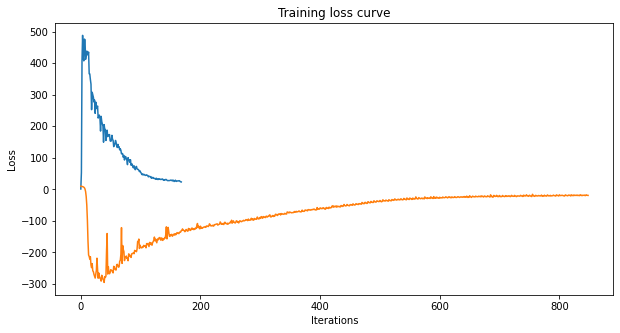

In [145]:
  plt.figure(figsize=(10, 5))
  plt.title('Training loss curve')
  plt.plot(EG_losses, label='Encoder + Generator')
  plt.plot(C_losses, label='Discriminator')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')

In [147]:
genr_imgs = wass.generate(noise).detach_().cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

ValueError: num must be 1 <= num <= 64, not 65

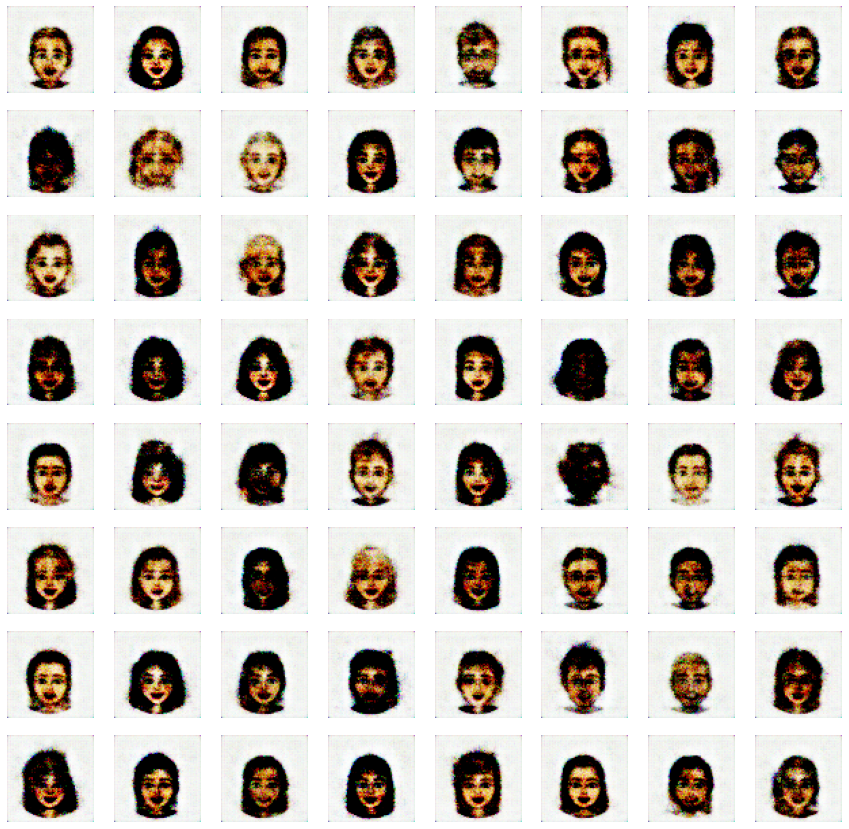

In [155]:
plt.figure(figsize=(15, 15))
for i in range(100):
    plt.subplot(8, 8, 1 + i)
    plt.axis('off')
    plt.imshow((np.transpose(genr_imgs[i],(1,2,0))))
 
#show 
plt.show()